# Practical Kernel Density Estimation with S&P 500 Data

![](./images/KDE.png)

> #### Strength of mind rests in sobriety; for this keeps your reason unclouded by passion.####
*Phythagoras*

## Introduction

I am reading a very interesting book - [The Physics of Wallstreet](https://www.amazon.com/Physics-Wall-Street-Predicting-Unpredictable/dp/0544112431 'link to Amazon page'), which talks about how mathematicians and physicists shaped the Wall Street we know today.

*(If you are interested in the stock market, you should read this brain-gasming gem.)*

One of the original super-heros in this book is Louis Bachelier - who was the first person to model the stock market fluctuations as Brownian motion (Normal Distribution, that is).

But twenty first century stock market returns are __NOT__ normally distributed, as seen in S&P 500, Dow Jones Index and many others.

Stock market are known to have "fat tail" events, where extreme market crashes and euphoria happens much more than what a Normal Distribution would predict.

This means, if we model S&P 500 daily returns as a Brownian Motion process following Bachelier's footsteps, we are going to be hugely surprized by market crashes and euphoria when we should not.

I attempted to use Kernel Density Estimation techniques to generate a PDF (Probability Density Function), and then estimate how likely the stock market is to crash from a day to day basis. (The KDE technique did a better job than a Normal Distribution.)

*(There are other ideas floating around, e.g. that stock market returns are Cauchy distributed - that will be for another notebook in the future. The purpose of this notebook is to demonstrate KDE using Python, and the data we use happens to be stock market returns)*

In [1]:
# import the essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1: Read in S&P 500 price data & visualize
We first read the S&P 500 daily OHLC (Open-High-Low-Close) data into a Pandas dataframe.

(At the time of writing, the ```pandas_datareader``` package do not work well due to the forever changing Yahoo! Finance and Google Finance API's, so the data was downloaded from Yahoo Finance and saved manually as a CSV file)

In [2]:
spy = pd.read_csv('./SPY.csv') 
spy['date'] = pd.to_datetime(spy['date'])   # convert the 'date' column to pd.Timestamp object
spy.set_index(spy['date'], inplace=True)    # index the DF using the 'date' column
spy.head()

,date,open,high,low,close,volume
date,,,,,,
2009-01-26,2009-01-26,83.59,85.3600,82.81,83.68,317922800
2009-01-27,2009-01-27,84.13,85.1500,83.30,84.53,273624300
2009-01-28,2009-01-28,86.40,87.9500,86.07,87.39,329873500
2009-01-29,2009-01-29,86.11,87.4901,84.47,84.55,294306700
2009-01-30,2009-01-30,84.98,85.4000,82.21,82.83,383282400


In [3]:
spy.index.min(), spy.index.max()   # display the dataframe's date ranges

(Timestamp('2009-01-26 00:00:00'), Timestamp('2019-01-25 00:00:00'))

### Step 2: Calculate daily returns

Since we are trying to model the S&P 500 daily returns, instead of the actual prices, we will use the super-handy ```pct_change()``` function, and put the daily return data into a new column: ```'pct_change'```.

The daily returns can also be calculated by the following:

```python
spy['pct_change'] = (spy['close'] - spy['close'].shift()) / spy['close'].shift()
```

But let's not re-invent the wheel - we should just use the ```pct_change()``` function, so here we go:

In [4]:
spy['pct_change'] = spy['close'].pct_change()
spy.dropna(inplace=True)    # get rid of the first data that will be NaN

### Step 3: Split training & test data

In machine learning, it is always good practice to split your data into "Training" and "Test" sets.

Let's say as we use 2009 to 2015's data as the training set, and anything that is 2016 onwards will be used as the test set.

In [5]:
train = spy['2009':'2015']
test = spy['2016':]

# check if we splitted the data correctly
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2009-01-27 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2016-01-04 00:00:00'),
 Timestamp('2019-01-25 00:00:00'))

In [6]:
train_returns = train['pct_change']   # training set returns

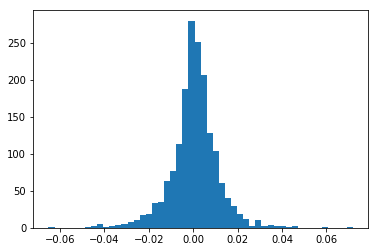

In [7]:
plt.hist(train_returns, bins=50);

### Step 4: Let's ~~ogle~~ 🧐 examine the daily returns histogram

As an engineer who ~~ogle~~ read charts all day, the histogram looks like a mal-nourished normal distribution - looks too skinny. But how does the actual returns compare to a real normal distribution?

I hacked together a Normal Distribtuion PDF function, because I am too lazy to import the ```scipy.stats.norm``` object.

(This is irrationally lazy, and is a bad practice - do NOT re-invent the wheel!)

Anyhow, here is the normal distribution PDF function (thanks [Wikipedia](https://en.wikipedia.org/wiki/Gaussian_function)):<br><br>
$
F(x) = \frac {1} {\sigma \sqrt{2 \pi}} e^{-(x-\mu)^2 / (2 \sigma^2)}
$

And this is the equation above translated into Python:
```python
def normal_pdf(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
```

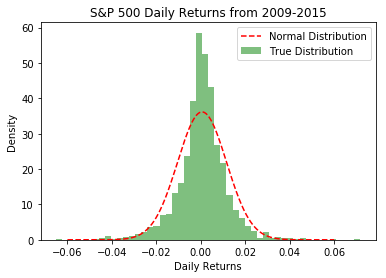

In [8]:
def normal_pdf(x, mu, sigma):
    '''
    Quick function hacked together to calculated the Normal distribution PDF based on 
    provided data, x, mean value mu, and standard deviation value sigma.
    '''
    return np.exp(-(x - mu)**2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

mu, sigma = train_returns.mean(), train_returns.std()  # training returns mean & std
xs = np.linspace(-0.06, 0.06, 1000)                    # x's between -0.06 to +0.06

plt.hist(train_returns, density=True, color='green', bins=50,   # draw the original histogram
         alpha=0.5, histtype='stepfilled', label='True Distribution')

plt.plot(xs, normal_pdf(xs, mu, sigma),                # plot out the PDF in red
         color='red', linestyle='--', label='Normal Distribution')

plt.title('S&P 500 Daily Returns from 2009-2015')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best');

### Step 5: Did the daily returns fit well to the Normal distribution?

As expected, the daily returns data do not fit well to the Normal distribution. It is NOT likely to be normal, since the real data are more *"skinny"*.

(In statistical terms, this "skinny" distribution is *Leptokurtic*, while normal distributions are *Mesokurtic*.)

But again, as an engineer, while I am (cautiously) optimistic of my ability to interpret charts, I can be diabolically skeptical of everything I say __unless__ I can prove it with numbers.

Let's prove to ourselves first that the returns data are indeed NOT normally distributed first.

(There are many ways to do this, but we are using the [Jarque-Bera test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html 'Scipy documentation') for this)

In [9]:
from scipy.stats import jarque_bera

def normality_test(x, alpha=0.05):
    '''
    A quickly hacked together normality test
    It prints out the result of the Jarque-Bera test based on comparing the p-value to alpha (default: 0.05)
    
    Quick note: I used Python 3.6's f-strings. You can modify it to .format() if you use an earlier 
    version of Python.
    
    '''
    _, p_value = jarque_bera(x)

    if p_value < alpha:
        print(f'p-value: {p_value:.3E}: p-value is lesser than alpha ({alpha:.3E})')
        print('Data is UNLIKELY to be normally distributed.')
    else:
        print(f'p-value: {p_value:.3E}: p-value is greater than / equal to alpha ({alpha:.3E})')
        print('Data is LIKELY to be normally distributed')
        
normality_test(train_returns, alpha=0.01)   # perform normality test on training set returns

p-value: 0.000E+00: p-value is lesser than alpha (1.000E-02)
Data is UNLIKELY to be normally distributed.


With the p-value of zero, it is now clear that S&P 500 daily returns from 2009 to 2015 are __not normally distributed__.

But what is the real, underlying distribution then? Generally there are 2 ways to do this:

i. Kernel Density Estimation

ii. Maximum Likehood Estimation

Obviously in this Notebook we will be approaching the problem via Kernel Density Estimation (KDE). We will use the ```KernelDensity``` object from ```sklearn.neighbors```.

### Step 6: Import the ```KernelDensity``` object & fit the daily returns data

In [10]:
from sklearn.neighbors import KernelDensity

Our ```train_returns``` is an 1D-array, meaning it has a ```shape``` of ```(rows,)```. However most ```sklearn``` functions require the data to be re-shaped to have 1 column, i.e. the shape needs to be ```(rows,1)```.

To make my code more readable, I defined an array ```train_returns_arr``` by re-shaping ```train_returns```.

Next, the ```kde``` variable is loaded up with the Kernel Density object, then fitted with the ```train_returns_arr``` data.

You may notice that I specified the bandwidth parameter as 0.001. That is just my "guestimate" of a reasonable bandwidth value. *(Guestimating the bandwidth value is more art than science: if you do not get it right the first time, just change to another value and see if it improves.)*

Feel free to experiment with other numbers for the ```bandwidth``` parameter - we will be optimizing this parameter later.

In [11]:
train_returns_arr = np.array(train_returns).reshape(-1, 1)
kde = KernelDensity(bandwidth = 0.001).fit(train_returns_arr)

### Step 7: 👀 Visualize the Probability Density Function (PDF) from the ```KernelDensity``` object

Now, ```kde```  is already fitted with the S&P 500 daily returns data - this means it is a PDF (Probability Density Function) on its own.

If $F(x)$ is the Probability Density Function (PDF) of the KDE, we can get the log probabilities values through the ```KernelDensity.score_samples()``` function, which returns $\ln(F(x))$.

Then calculating the actual PDF values is quite straight forward: just calculate the exponential values (```np.exp```), and you will get: 

$$F(x) = e^{\ln(F(x))}$$

In Python:

```python
log_probs = kde.score_samples(xs.reshape(-1, 1))    # get the log probabilities
kde_pdf = np.exp(log_probs)                         # calculate actual PDF
```

I have also plotted the true distribution as histogram, the normal distribution and the KDE fitted distribution in the code below.

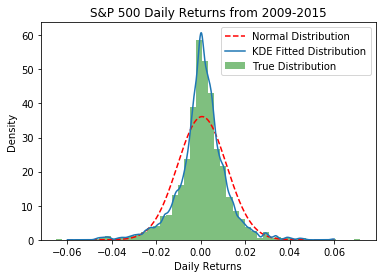

In [12]:
mu, sigma = train_returns.mean(), train_returns.std()
xs = np.linspace(-0.06, 0.06, 1000)

log_probs = kde.score_samples(xs.reshape(-1, 1))
kde_pdf = np.exp(log_probs)

plt.hist(train_returns, density=True, color='green', bins=50, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')
plt.plot(xs, kde_pdf, label='KDE Fitted Distribution')
plt.title('S&P 500 Daily Returns from 2009-2015')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best');

### Step 8: What do you see 👀 ? ###

*(I have good and bad news.)*

First, the good news: the ```KDE Fitted Distribution``` PDF fits the ```True Distribution``` data much better compared to the ```Normal Distribution``` curve, i.e. it follows the shape of the ```True Distribution```.

Now on to the bad news: If you zoom into the tails, e.g. -0.02 to -0.06 and 0.02 to 0.06, you can see that the KDE fitted PDF overfits to the True Distribution. To illustrate what I mean, I re-produced the same chart below, but zooms into one of the tails.

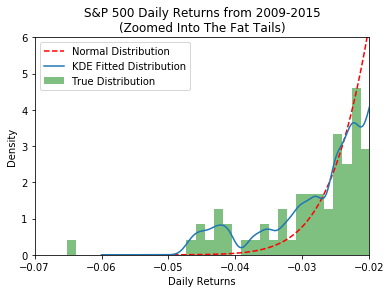

In [13]:
plt.hist(train_returns, density=True, color='green', bins=100, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')
plt.plot(xs, kde_pdf, label='KDE Fitted Distribution')
plt.title('S&P 500 Daily Returns from 2009-2015\n(Zoomed Into The Fat Tails)')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.xlim([-0.07, -0.02])
plt.ylim([0, 6])
plt.legend(loc='upper left');

__Uh-oh.__ 😫

From the chart above we can see that the ```KDE Fitted Distribution``` curve was fooled by the random noise in the ```True Distribution``` data. It looks nothing like a "fat tail" distribution.

### Step 9: Optimize the ```KernelDensity``` object

Luckily the good folks at ```sklearn``` created the ```GridSearchCV``` function: This can help us fine tune the ```KernelDensity``` parameters so that it generalize better to the noisy data.

If you are not familiar with the ```GridSearchCV``` function, here is how you work with it:

1. Define a "parameter grid" that you want to optimize as a Python dictionary, for example:
```python
params = {'bandwidth' : np.linspace(-0.0001, 0.01, 50)} # optimize bandwidth
```
or
```python
params = {
    'bandwidth' : np.linspace(-0.0001, 0.01, 30),          # optimize bandwidth
    'kernel': ['gaussian', 'epanechnikov', 'exponential']  # and kernel type
         }
```

2. Run the ```GridSearchCV``` function, like this:
```python
grid = GridSearchCV(KernelDensity(), 
                    param_grid=params, 
                    cv=20).fit(train_returns_arr)
```

3. Read the best parameters via ```grid.best_params_```

(Here I optimized the ```bandwidth``` parameter, but not the ```kernel``` parameter, but feel free to try both.)

In [14]:
from sklearn.model_selection import GridSearchCV

__Warning: Due to grid search, the following will take much longer than the other cells above.__

In [15]:
params = {'bandwidth' : np.linspace(0.001, 0.01, 50)}
grid = GridSearchCV(KernelDensity(), 
                    param_grid=params, 
                    cv=20,                        # 20 cross validation runs
                    n_jobs=-1).fit(train_returns_arr)

In [16]:
grid.best_params_

{'bandwidth': 0.004306122448979592}

### Step 10: Re-fit the ```KernelDensity``` with the optimized ```bandwidth``` value

The ```grid``` has a best ```bandwidth``` parameter of 0.0043.

Next, we will re-plot the charts, but this time the KDE will be using the optimized ```bandwidth``` parameter.

In [17]:
best_kde = KernelDensity(bandwidth=grid.best_params_['bandwidth']).fit(train_returns_arr)

log_probs = best_kde.score_samples(xs.reshape(-1,1))
best_kde_pdf = np.exp(log_probs)

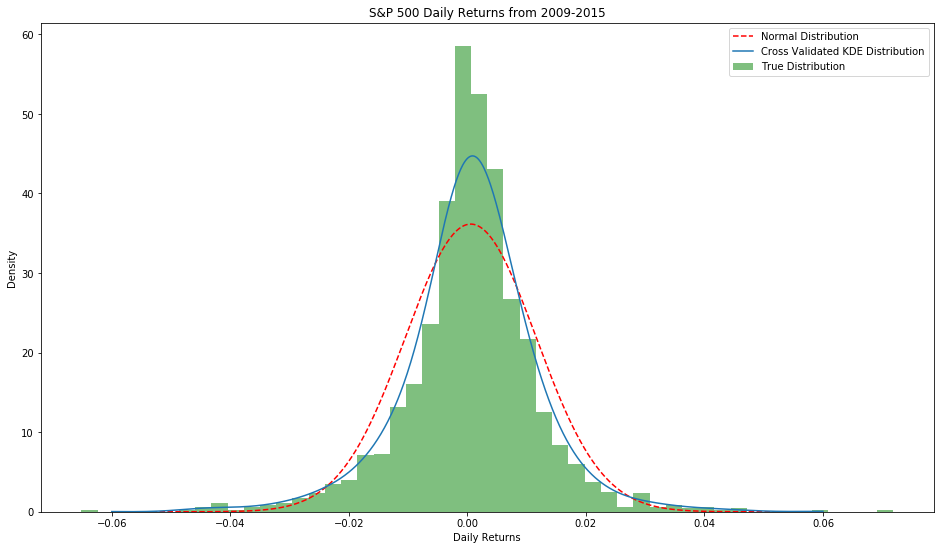

In [18]:
plt.subplots(figsize=(16,9))
plt.hist(train_returns, density=True, color='green', 
         bins=50, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', 
         linestyle='--', label='Normal Distribution')
plt.plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')
plt.title('S&P 500 Daily Returns from 2009-2015')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best');

### Step 11: Is the optimized ```KernelDensity``` any better than before?

At first glance, the KDE curve looks much better than before. It did not seem to overfit to the random noise at both left and right tails.

But let's zoom into BOTH fat tail regions to see whether the overfitting has improved.

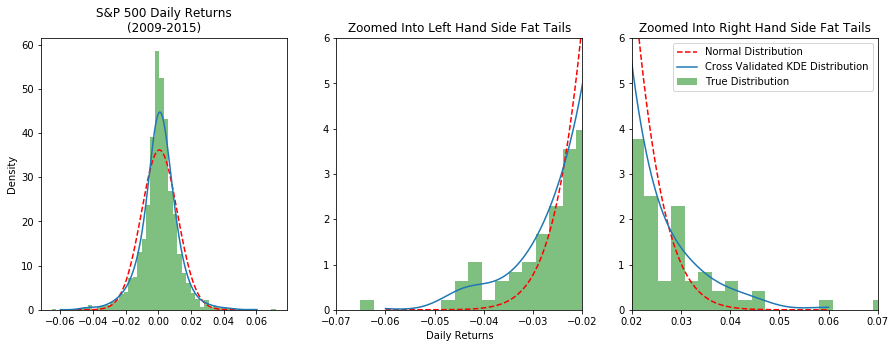

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].hist(train_returns, density=True, color='green', bins=50, alpha=0.5, 
               histtype='stepfilled', label='True Distribution')
    ax[i].plot(xs, normal_pdf(xs, mu, sigma), color='red', 
         linestyle='--', label='Normal Distribution')
    ax[i].plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')

ax[0].set_ylabel('Density')
ax[1].set_xlabel('Daily Returns')
ax[0].set_title('S&P 500 Daily Returns\n(2009-2015)')
ax[1].set_title('Zoomed Into Left Hand Side Fat Tails')
ax[2].set_title('Zoomed Into Right Hand Side Fat Tails')  

ax[1].set_xlim([-0.07, -0.02])
ax[1].set_ylim([0, 6])
ax[2].set_xlim([0.02, 0.07])
ax[2].set_ylim([0, 6])

ax[2].legend();

__My verdict:__ This KDE PDF is by no means perfect, but much better than before.

We can now put it into good use. Let's become a stock market doomsday predictor by calculating how likely the stock market will crash more than 4% a day.

### So what is the probability of S&P 500 crashing down more than 4% ?

The answer is... It depends on how you want to make the prediction.

In the example below, I used 3 different methods:

1. Using the actual probability, e.g. based on the number of times the S&P 500 actually crashed more than 4%.

2. Using the optimized KDE's PDF.

3. Modelling the stock market returns as a Normal Distribution (which we know is NOT the right approach)

In [20]:
from scipy.stats import norm

# ACTUAL probability of crashing more than 4%
actual_data_prob = np.sum(train_returns < -0.04) / len(train_returns)

# Predicted probability of crashing more than 4% based on the optimized KDE
crash_range = np.linspace(-0.1, -0.04, 1000)
best_kde_probs = np.exp(best_kde.score_samples(crash_range.reshape(-1,1)))
best_kde_probs_integrated = np.trapz(best_kde_probs, x=crash_range)

# Predicted probability of crashing more than 4% based on normal distribution
normal_probs = norm.cdf(-0.04, train_returns_arr.mean(), train_returns_arr.std())

# print out the results
print('Actual probability:              {:.3%}'.format(actual_data_prob))
print('Best Fit KDE probability:        {:.3%}'.format(best_kde_probs_integrated))
print('Normal distribution probability: {:.3%}'.format(normal_probs))

Actual probability:              0.573%
Best Fit KDE probability:        0.521%
Normal distribution probability: 0.012%


__Brilliant. The results are in!__ 😍😍😍

Within 2009-2015 (our training set's time period), the S&P 500 crashed (more than 4%) from a day to day basis, 0.573% of the time.

The best fit (optimized) KDE predicted 0.521%. Not bad at all, I would say.

But the normal distribution prediction of 0.012% is no where near the reality.

I will let you draw your own conclusions, but I hope that you enjoyed reading and playing with the code!

> #### Keep calm and code in Python####
> *OCY*

### p/s: Extra notes about calculating the KDE's probabilities

You may notice that I calculated the KDE's probabilities using the following:

```python
# Predicted probability of crashing more than 4% based on th optimized KDE
crash_range = np.linspace(-0.1, -0.04, 1000)
best_kde_probs = np.exp(best_kde.score_samples(crash_range.reshape(-1,1)))
best_kde_probs_integrated = np.trapz(best_kde_probs, x=crash_range)
```

If you are feeling confused: Basically we are trying to calculate the probability of ```train_returns_arr``` having a value of lesser than -0.04. That means we need to calculate the probability it having values between -1.0 and -0.04. This means we are looking for a CDF value:

$$
Probability = \int_{-1.0}^{-0.04} F(x) dx
$$

(The lower limit of -1.0 is because the most the S&P 500 can drop is dropping to zero, hence the ```pct_change()``` would be -1.0, or -100%)

The ```sklearn```'s ```KernelDensity``` object does not include a CDF (Cumulative Density Function) function, so we can only **estimate** the CDF value by approximating the intergration - In this example I used ```np.trapz()``` function. (```trapz``` means trapezium rule.)

In the code above, ```crash_range``` ranges from -10% to -4%, instead of from -100% and -4%. -10% is just an arbitarily small enough number that I chose as the lower limit of the integration, as the KDE's PDF would predict 0% probability for anything smaller than -0.10 anyway.